In [16]:
# Import Dependencies
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

In [17]:
# Load csv into DataFrame
df_earthquakes = pd.read_csv("Resources/eq_data.csv")

In [18]:
# Connect to/Create database
conn = sqlite3.connect("Resources/earthquakes.sqlite")

In [19]:
# Write the dataframe to the earthquakes database into eq_data table
df_earthquakes.to_sql("eq_data", conn, if_exists="replace", index=False)

7449

In [20]:
# Load SELECT data into DataFrame
df_magnitude_by_magType = pd.read_sql_query("SELECT mag, magType FROM eq_data", conn)

In [21]:
# Calculate the mean magnitude for each magType
df_grouped = df_magnitude_by_magType.groupby("magType").mean()
df_grouped

,mag
magType,
Ml,3.600000
ma,3.000000
mb,3.650000
mc,3.114615
md,3.159779
mh,3.415385
ml,3.324466
mlr,3.804760
mw,3.828904


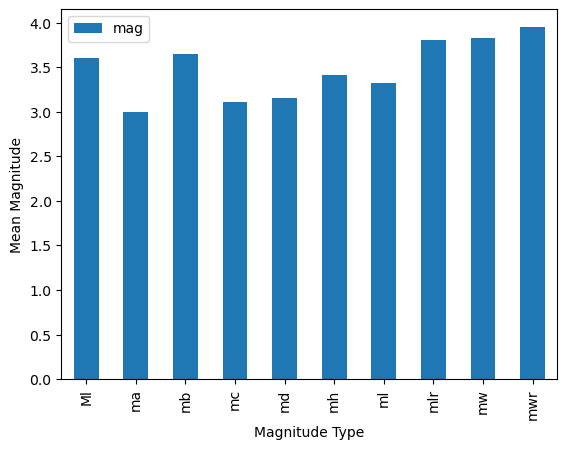

In [22]:
# Plot the mean magnitude by magnitude type
df_grouped.plot(kind="bar")

# Label x and y axis
plt.xlabel("Magnitude Type")
plt.ylabel("Mean Magnitude")

# Show the plot
plt.show()

